학습 데이터 셋 표준화

In [ ]:
scaler = StandardScaler()
# 학습 데이터 각 변수의 평균값과 표준편차를 저장한 후, 이를 사용하여 학습 및 평가용 데이터를 변환
x_train_[col_numerical] = scaler.fit_transform(x_train_[col_numerical])
x_valid[col_numerical] = scaler.transform(x_valid[col_numerical])

모델의 성능 평가를 위해 제곱근평균제곱오차(RMSE)를 반환하는 함수를 작성합니다. 

In [ ]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환
def rmse(y_true,y_pred):

    return round(mean_squared_error(y_true, y_pred,squared=False),4)

### 5.2 릿지 회귀 모델
선형 모델 중 하나인 릿지 모델을 사용
릿지 모델은 계수의 제곱에 비례하여 벌칙을 부여하는 **L2 정규화**를 사용

릿지 회귀 모델에서 튜닝해야할 매개변수는 정규화의 세기를 나타내는 **alpha**


하이퍼파라미터 종류: ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'random_state', 'solver', 'tol']

1. alpha: 규제의 강도
2. solver: 계산에 사용할 알고리즘
3. tol: 정밀도 (solver가 svd와 cholesky일 경우에는 의미 없음.)

In [ ]:
# log 단위(1e+01)로 1.e-02 ~ 1.e+01 구간에 대해 매개변수를 탐색
# solver_list = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
ridge_params = {'alpha': np.logspace(-2, 1, 6)}

매개변수 탐색을 위해 그리드 서치 기법을 사용 

GridSearchCV는 매개변수 각 조합에 대해 모델을 훈련, K-폴드 교차검증으로 평가. cv의 디폴트는 5  

refit=True 로 설정할 경우, 매개변수 탐색 후, 전체 데이터셋에서 최적의 하이퍼파라미터를 사용하여 모델을 재학습

In [ ]:
# GridSearchCV를 이용하여 Ridge 모델을 저장
ridge_model = GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_root_mean_squared_error', refit=True) # error가 작아야 좋기 때문에 negative 지표로
ridge_model.fit(x_train_,y_train_)  

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 0.01      ,  0.03981072,  0.15848932,  0.63095734,  2.51188643,
       10.        ])},
             scoring='neg_root_mean_squared_error')

In [ ]:
col_cv_results = ['params','mean_test_score','rank_test_score']
pd.DataFrame(ridge_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,{'alpha': 0.01},-0.006547,6
1,{'alpha': 0.039810717055349734},-0.005236,5
2,{'alpha': 0.15848931924611134},-0.004414,4
3,{'alpha': 0.630957344480193},-0.003830,3
4,{'alpha': 2.5118864315095797},-0.003498,2
5,{'alpha': 10.0},-0.003386,1


> alpha 가 10인 경우, 모델의 성능이 가장 우수

### 5.3 랜덤 포레스트 모델 
랜덤 포레스트는 행 데이터를 샘플링한 후, 병렬로 수행된 다수의 결정 트리로부터 예측한 평균값을 출력

랜덤 포레스트에서 튜닝해야할 변수

*  n_estimators : 결정 트리 갯수 ( default : 100 )
*  max_depth : 트리의 최대 깊이 ( default : None ) 
*  min_samples_split : 노드를 분할하기 위한 최소 샘플 갯수 ( default : 2 )
*  min_samples_leaf : 리프 노드가 되기 위한 최소 샘플 갯수 ( default : 1 )
*  max_features : 각 노드에서 분기시 사용할 최대 특성 갯수 ( default : 1.0 - 전체 특성 갯수 )
*  bootstrap : 중복을 허용한 샘플링 여부 ( default : True ) 


결정 트리의 갯수가 커질수록 계산시간이 증가하므로, 시간과 성능의 트레이드 오프로 결정

In [ ]:
# GridSearchCV를 이용하여 Randomforest 모델을 저장
rf_params = {'max_features': [5,6], 'n_estimators': [120, 200]}
rf_model = GridSearchCV(RandomForestRegressor(random_state=1), param_grid=rf_params, scoring='neg_root_mean_squared_error', refit=True) 
rf_model.fit(x_train_,y_train_)  

GridSearchCV(estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_features': [5, 6], 'n_estimators': [120, 200]},
             scoring='neg_root_mean_squared_error')

In [ ]:
pd.DataFrame(rf_model.cv_results_)[col_cv_results].sort_values(by='rank_test_score')

,params,mean_test_score,rank_test_score
1,"{'max_features': 5, 'n_estimators': 200}",-0.002189,1
3,"{'max_features': 6, 'n_estimators': 200}",-0.002191,2
0,"{'max_features': 5, 'n_estimators': 120}",-0.002194,3
2,"{'max_features': 6, 'n_estimators': 120}",-0.002196,4


In [ ]:
# # GridSearchCV를 이용하여 CatBoost 모델을 저장
# cbr_params = {'depth': [10], 'learning_rate': [0.01]}
            
# cbr_model = GridSearchCV(CatBoostRegressor(random_state=1, iterations=100), param_grid=cbr_params, scoring='neg_root_mean_squared_error', cv=2, n_jobs=-1, refit=True) 
# cbr_model.fit(x_train,y_train)

cbr_model = CatBoostRegressor(random_state=1, iterations=100)
cbr_model.fit(x_train_,y_train_)

Learning rate set to 0.272088
0:	learn: 0.0117220	total: 13.4ms	remaining: 1.32s
1:	learn: 0.0090807	total: 24ms	remaining: 1.18s
2:	learn: 0.0071356	total: 34.3ms	remaining: 1.11s
3:	learn: 0.0057498	total: 44.4ms	remaining: 1.06s
4:	learn: 0.0048378	total: 54.9ms	remaining: 1.04s
5:	learn: 0.0042021	total: 65.3ms	remaining: 1.02s
6:	learn: 0.0037901	total: 75.6ms	remaining: 1s
7:	learn: 0.0034952	total: 85.7ms	remaining: 986ms
8:	learn: 0.0032649	total: 96.4ms	remaining: 975ms
9:	learn: 0.0031080	total: 107ms	remaining: 963ms
10:	learn: 0.0029809	total: 117ms	remaining: 950ms
11:	learn: 0.0028827	total: 128ms	remaining: 942ms
12:	learn: 0.0028011	total: 140ms	remaining: 936ms
13:	learn: 0.0027506	total: 152ms	remaining: 934ms
14:	learn: 0.0027006	total: 163ms	remaining: 922ms
15:	learn: 0.0026531	total: 173ms	remaining: 906ms
16:	learn: 0.0026006	total: 183ms	remaining: 895ms
17:	learn: 0.0025231	total: 195ms	remaining: 888ms
18:	learn: 0.0024960	total: 207ms	remaining: 881ms
19:	lea

In [ ]:
# 최적의 하이퍼파라미터로 학습된 릿지 회귀 모델을 저장
best_ridge = ridge_model.best_estimator_

# 최적의 하이퍼파라미터로 학습된 랜덤포레스트 모델을 저장
best_rf = rf_model.best_estimator_

# 최적의 하이퍼파라미터로 학습된 캣부스트 회귀 모델을 저장
best_cbr = cbr_model.best_estimator_

<a name='05-04'></a>
### 5.4 최종 모델 구축 

릿지 모델과 랜덤 포레스트 모델을 평가하고, 이 둘의 조합인 앙상블 모델을 구축합니다.


In [ ]:
# 학습용 데이터셋의 타깃 변수 예측 
y_pred_tr_ridge = np.expm1(best_ridge.predict(x_train_))
y_pred_tr_rf = np.expm1(best_rf.predict(x_train_))
y_pred_tr_cbr = np.expm1(cbr_model.predict(x_train_))

# 검증용 데이터셋의 타깃 변수 예측 
y_pred_va_ridge = np.expm1(best_ridge.predict(x_valid))
y_pred_va_rf = np.expm1(best_rf.predict(x_valid))
y_pred_va_cbr = np.expm1(cbr_model.predict(x_valid))


# 앙상블 모형의 학습 및 검증 데이터에 대한 타깃 변수 예측 
y_pred_tr_en= np.mean([y_pred_tr_ridge, y_pred_tr_rf, y_pred_tr_cbr], axis=0)
y_pred_va_en= np.mean([y_pred_va_ridge, y_pred_va_rf, y_pred_va_cbr], axis=0)

# 학습 데이터셋의 RMSE 계산 
rmse_tr_ridge = rmse(np.expm1(y_train_), y_pred_tr_ridge)
rmse_tr_rf = rmse(np.expm1(y_train_), y_pred_tr_rf)
rmse_tr_en = rmse(np.expm1(y_train_), y_pred_tr_en)
rmse_tr_cbr = rmse(np.expm1(y_train_), y_pred_tr_cbr)

# 검증 데이터셋의 RMSE 계산 
rmse_va_ridge = rmse(np.expm1(y_valid), y_pred_va_ridge)
rmse_va_rf = rmse(np.expm1(y_valid), y_pred_va_rf)
rmse_va_en = rmse(np.expm1(y_valid), y_pred_va_en)
rmse_va_cbr = rmse(np.expm1(y_valid), y_pred_va_cbr)


print(f'\n**** RIDGE\n')
print(f'Train RMSE: {rmse_tr_ridge}\n')
print(f'Valid RMSE: {rmse_va_ridge}\n')

print(f'\n**** Random Forest\n')
print(f'Train RMSE: {rmse_tr_rf}\n')
print(f'Valid RMSE: {rmse_va_rf}\n')

print(f'\n**** CatBoostRegressor\n')
print(f'Train RMSE: {rmse_tr_cbr}\n')
print(f'Valid RMSE: {rmse_va_cbr}\n')


print(f'\n**** Ensemble\n')
print(f'Train RMSE: {rmse_tr_en}\n')
print(f'Valid RMSE: {rmse_va_en}\n')


**** RIDGE

Train RMSE: 4.0353

Valid RMSE: 8.5042


**** Random Forest

Train RMSE: 1.5902

Valid RMSE: 6.6581


**** CatBoostRegressor

Train RMSE: 0.713

Valid RMSE: 7.5901


**** Ensemble

Train RMSE: 1.948

Valid RMSE: 6.8632



In [ ]:
scaler = StandardScaler()
x_train[col_numerical] = scaler.fit_transform(x_train[col_numerical])
x_test[col_numerical] = scaler.transform(x_test[col_numerical])

In [ ]:
y_train = np.log1p(y_train)

In [ ]:
rf_params = {'max_features': [5,6], 'n_estimators': [120, 200]}
rf_model_test = GridSearchCV(RandomForestRegressor(random_state=1), param_grid=rf_params, scoring='neg_root_mean_squared_error', refit=True) 
rf_model_test.fit(x_train,y_train) 

best_rf_test = rf_model_test.best_estimator_

cbr_model_test = CatBoostRegressor(random_state=1, iterations=100)
cbr_model_test.fit(x_train,y_train)

Learning rate set to 0.237657
0:	learn: 0.0062502	total: 12.6ms	remaining: 1.24s
1:	learn: 0.0060661	total: 22.6ms	remaining: 1.11s
2:	learn: 0.0059122	total: 32.3ms	remaining: 1.04s
3:	learn: 0.0057648	total: 41.8ms	remaining: 1s
4:	learn: 0.0056872	total: 51.5ms	remaining: 979ms
5:	learn: 0.0055641	total: 61.1ms	remaining: 958ms
6:	learn: 0.0054438	total: 70.8ms	remaining: 941ms
7:	learn: 0.0053697	total: 80.4ms	remaining: 924ms
8:	learn: 0.0052722	total: 89.9ms	remaining: 909ms
9:	learn: 0.0051790	total: 99.6ms	remaining: 897ms
10:	learn: 0.0051081	total: 110ms	remaining: 886ms
11:	learn: 0.0050302	total: 119ms	remaining: 875ms
12:	learn: 0.0049715	total: 129ms	remaining: 863ms
13:	learn: 0.0049095	total: 138ms	remaining: 849ms
14:	learn: 0.0048536	total: 148ms	remaining: 840ms
15:	learn: 0.0047468	total: 158ms	remaining: 828ms
16:	learn: 0.0046790	total: 167ms	remaining: 818ms
17:	learn: 0.0045858	total: 177ms	remaining: 807ms
18:	learn: 0.0045080	total: 187ms	remaining: 797ms
19:	

In [ ]:
y_pred_test_rf = np.expm1(best_rf_test.predict(x_test))
y_pred_test_cbr = np.expm1(cbr_model_test.predict(x_test))
y_pred_test_en= np.mean([y_pred_test_rf, y_pred_test_cbr], axis=0)

rmse_test_en = rmse(np.expm1(y_test), y_pred_test_en)
rmse_test_cbr = rmse(np.expm1(y_test), y_pred_test_cbr)
rmse_test_rf = rmse(np.expm1(y_test), y_pred_test_rf)

print(f'Ensemble: Test RMSE: {rmse_test_en}')
print(f'CBR: Test RMSE: {rmse_test_cbr}')
print(f'RF: Test RMSE: {rmse_test_rf}')

Ensemble: Test RMSE: 7.0707
CBR: Test RMSE: 7.2802
RF: Test RMSE: 7.1301


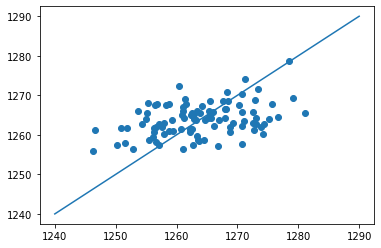

In [ ]:
plt.scatter(np.expm1(y_valid), y_pred_va_en)
x = np.linspace(1240,1290)
y = np.linspace(1240,1290)
plt.plot(x,y)

테스트 데이터로 세가지 모델에 대한 성능을 비교합니다.

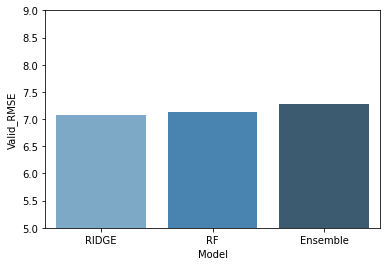

In [ ]:
recap_model = ['RIDGE','RF','Ensemble']
rmse_valid = [rmse_test_en,rmse_test_rf,rmse_test_cbr]
df_recap = pd.DataFrame({'Model':recap_model, 'Valid_RMSE':rmse_valid})
ax = sns.barplot(x='Model',y='Valid_RMSE',data=df_recap,palette='Blues_d')
ax.set_ylim([5,9])
plt.show()

랜덤 포레스트와 같은 트리 기반 모델에서는 각 변수의 중요도 정보를 함께 제공

특정 변수로 분기되었을 시 제곱오차(squared_error)가 크게 감소한 변수일수록 중요도가 향상

분류 문제일 경우에는, 불순도(Gini, entropy)가 크게 감소할수록 해당 특성의 중요도가 향상

전체 변수의 중요도 합은 1이며, 이는 상대적 의미를 가짐

In [ ]:
print('*** MODEL R2_SCORE')
print('rf :',r2_score(np.expm1(y_test), y_pred_test_rf))
print('CBR :',r2_score(np.expm1(y_test), y_pred_test_cbr))
print('Ensemble :',r2_score(np.expm1(y_test), y_pred_test_en))

*** MODEL R2_SCORE
rf : 0.15946752359228278
CBR : 0.12371272694334823
Ensemble : 0.17342489441307707


In [ ]:
def objectiveCBR(trial):

    param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    # 학습 모델 생성
    model = CatBoostRegressor(**param)
    cbr_model = model.fit(x_train, y_train, verbose=True) # 학습 진행

    # 모델 성능 확인
    y_pred_test_cbr = np.expm1(cbr_model.predict(x_test))
    rmse_test_cbr = rmse(np.expm1(y_test), y_pred_test_cbr)
  
    return rmse_test_cbr

In [ ]:
# optuna 진행
cbr_study = optuna.create_study(direction="minimize")

cbr_study.optimize(objectiveCBR, n_trials=50, timeout=600)

In [ ]:
print("Number of finished trials: {}".format(len(cbr_study.trials)))

print("Best trial:")
trial = cbr_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def objectiveRF(trial):

    param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }

    # 학습 모델 생성
    model = RandomForestRegressor(**param)
    rf_model = model.fit(x_train, y_train) # 학습 진행

    # 모델 성능 확인
    y_pred_test_rf = np.expm1(rf_model.predict(x_test))
    rmse_test_rf = rmse(np.expm1(y_test), y_pred_test_rf)
  
    return rmse_test_rf

In [ ]:
rf_study = optuna.create_study(direction="minimize")

rf_study.optimize(objectiveRF, n_trials=50, timeout=600)

In [ ]:
print("Number of finished trials: {}".format(len(rf_study.trials)))

print("Best trial:")
trial = rf_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))